# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, we build a Convolution Network to classify German Traffic Signs. This is the second porject of the first term in the Udacity Self Driving Car Engineer nanodegree. The objective is to achive at least 93% accuracy on the test sample with a Neural Network we have to implement.
We roughly follow the ideas from the paper http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf.
First we explore the Data, augment it and preprocess it.
We then build the Convolution Network, whose architecture is described further below.
Finally, we train it and test it on the test data, and also on an extra set of images we obtained from the internet, to further evaluate its robustness.

---
## Step 0: Load The Data

In [1]:
# In general, but specially if we are going to use AWS, it is good practice
# to automate the routine that downloads and unzips the data

import os
from urllib.request import urlretrieve
from zipfile import ZipFile

Data_dir = "Data"
source = "https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip"

if not os.path.exists(Data_dir):
    os.makedirs(Data_dir)

target = os.path.join(Data_dir, "Data.zip")

if not os.path.isfile(target):
    urlretrieve(source, target)
    print("Finished downloading datasets.")
else:
    print("Datasets have already been downloaded.")

Finished downloading datasets.


In [2]:
# we now unzip it if necessary

unzipped_ = os.path.isdir(os.path.join(Data_dir, "training"))

if not unzipped_:
    with ZipFile(target, "r") as zipped:
        zipped.extractall(Data_dir)
    print("Finished extracting zip files.")
else:
    print("Unzipped files found - skipping.")

Finished extracting zip files.


In [3]:
# Load pickled data
import pickle

training_file = 'Data/train.p'
validation_file= 'Data/valid.p'
testing_file = 'Data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_validation, y_validation = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**



### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [4]:
### Quick overview of the dataset
import numpy as np

n_train = len(X_train)
n_validation = len(X_validation)
n_test = len(X_test)
image_shape = X_train[0].shape
sign_classes, class_indices, class_counts = np.unique(y_train, return_index = True, return_counts = True)
sign_classes_v, class_indices_v, class_counts_v = np.unique(y_validation, return_index = True, return_counts = True)
sign_classes_t, class_indices_t, class_counts_t = np.unique(y_test, return_index = True, return_counts = True)
n_classes = len(class_counts)

print("Number of training examples =", n_train)
print("Number of validating examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validating examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

Here we visualize our data, allowing us to become familiar with its structure, as well as with potential issues that might arise when developing and training our network.
We first take a look at a few of the types of traffic signs in our data, and we then compute and plot the frequency of each label in our train, validation and test data sets.

Label 7: Speed limit (100km/h)                               1290 samples


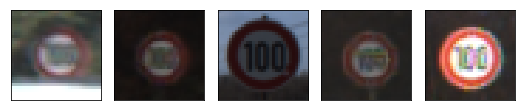

Label 11: Right-of-way at the next intersection               1170 samples


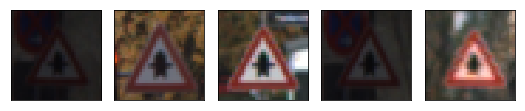

Label 18: General caution                                     1080 samples


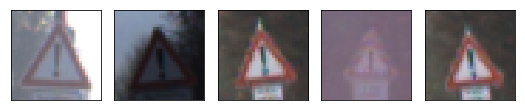

Label 28: Children crossing                                   480 samples


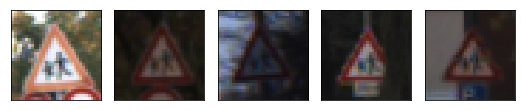

Label 31: Wild animals crossing                               690 samples


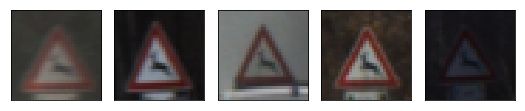

Label 35: Ahead only                                          1080 samples


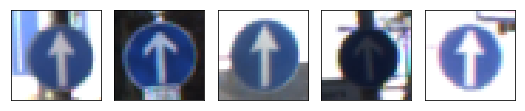

Label 41: End of no passing                                   210 samples


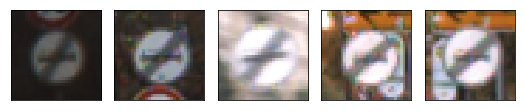

In [5]:
import random
from pandas.io.parsers import read_csv
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
signnames = read_csv("signnames.csv").values[:, 1]

col_width = max(len(name) for name in signnames)
labels_fraction = 0.15

for label, label_index, label_count in zip(sign_classes, class_indices, class_counts):
    if random.uniform(0,1)<labels_fraction:
        print("Label %i: %-*s  %s samples" % (label, col_width, signnames[label], str(label_count)))
        fig = plt.figure(figsize = (7, 5))
        fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.15)
        random_indices = random.sample(range(label_index, label_index + label_count), 5)
        for i in range(5):
            axis = fig.add_subplot(1, 5, i + 1, xticks=[], yticks=[])
            axis.imshow(X_train[random_indices[i]])
        plt.show()
        



## Frequencies
We now want to plot the frequncies of each label in each of our data sets (trainig, validation and testing).

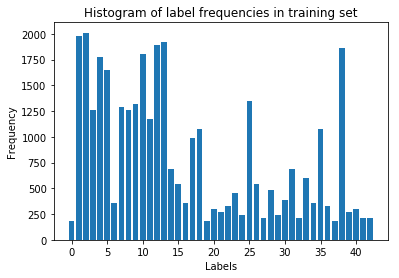

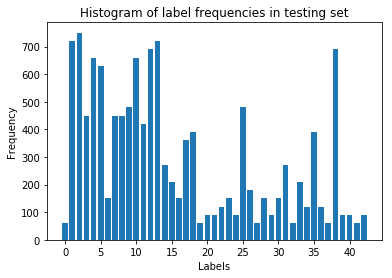

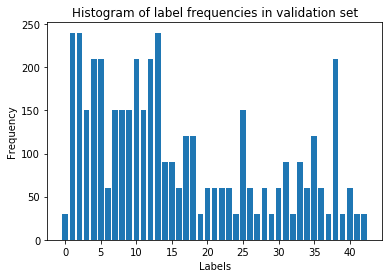

In [12]:
label_dict = {
    "training": class_counts,
    "validation": class_counts_v,
    "testing": class_counts_t
}

for stage, y in label_dict.items():
    plt.bar( np.arange( 43 ), y, align='center' )
    plt.title("Histogram of label frequencies in {} set".format(stage))
    plt.xlabel("Labels")
    plt.ylabel("Frequency")
    plt.xticks(range(0, 43, 5))    
    plt.savefig("examples/Frequencies_{}.png".format(stage))
    plt.show()
    

### Augmenting the dataset

For some of our labels we have very few examples in our data. A simple way to obtain more examples, while at the same time increasing the robustness of our model, is to perturbate the images we already have. 
Whether the sign is displaced a couple pixels, slightly rotated or a bit blurred should (ideally) not have an effect on the way we would classify it. Therefore, we can introduce these transformations of our images to increase the amount of data we will feed to our classifier.

Usually it would be a good idea to also introduce some redundancy for those labels that are underrepresented in our training data, but since the distribution of the labels looks fairly similar across all three data sets, this is a step we will not introduce (implicitly, we are assuming that the frequency of the signs in the real world is similar to the one we see in our data, and therefore that a random sample would look not too different from the data set).

Below we will introduce a few transformations that we will use to augment the data:
* Shifts
* Rotations
* Homography
* Blurs
* Noise

1


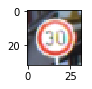

In [7]:
index = random.randint(0, len(X_train))
image = X_train[index].squeeze()
plt.figure(figsize=(1,1))
plt.imshow(image)
print(y_train[index])

In [8]:
import cv2


def apply_shift(img):
    which_axis = random.randrange(2)
    shapex = img.shape[0]
    shapey = img.shape[1]
    
    if which_axis < 1:
        aux0, aux1 = img[0,:], img[1,:]
        img[0,:], img[1,:] = img[shapex-2,:], img[shapex-1,:]
        img[shapex-2,:], img[shapex-1,:] = aux0, aux1
         
    
    else:
        aux0, aux1 = img[:,0], img[:,1]
        img[:,0], img[:,1] = img[:,shapey-2], img[:,shapey-1]
        img[:,shapey-2], img[:,shapey-1] = aux0, aux1
         
    
    return img

def apply_rotation(img):
    M = cv2.getRotationMatrix2D((16,16),np.random.uniform(-20,20),1)
    return cv2.warpAffine(img, M, (32,32))

def apply_homography(img):
    source_points = np.array([[12,16], [16,20], [20,16], [16,12]],np.float32)
    noise = np.random.normal(scale=0.2, size=source_points.shape)
    target_points = source_points + noise
    h, status = cv2.findHomography(source_points, target_points)
    im_out = cv2.warpPerspective(img, h, dsize=(32,32))
    return im_out

def apply_blur(img):
    return cv2.GaussianBlur(img,(3,3),0)

def apply_noise(img):
    noise = np.random.normal(scale=3.0,size=img.shape)
    return np.clip(np.round(img + noise), 0.0, 256.0).astype(np.uint8)

Now that we have defined our transformations, we will runa  quick example of what this transformations look like.

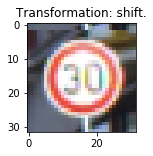

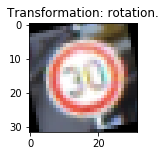

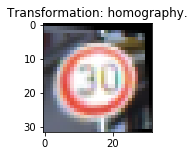

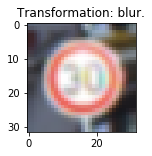

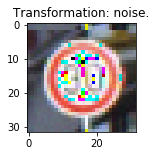

In [9]:
l_transforms = [apply_shift, apply_rotation, apply_homography, apply_blur, apply_noise] 
l_nm = ["shift", "rotation", "homography", "blur", "noise"] 

for tran, nm in zip(l_transforms, l_nm):
    img = tran(X_train[index])
    plt.figure(figsize=(2,2))
    plt.title("Transformation: {}.".format(nm))
    plt.imshow(img)
    plt.savefig("examples/Transformation_{}.png".format(nm))
    



We are now ready to augment the data. Applying these transformations to our training set will increase the amount of training examples by 500%! We expect our model to be more robust, but it will also take longer to train. We will actually run the data augmentation with each batch of our training (and it will already be in grayscale, which explains the shape we are imposing).

In [10]:
from sklearn.utils import shuffle

def build_augmented_dataset(X, Y):
    
    shifts = [np.reshape(apply_shift(x),(32,32,1)) for x in X]  
    rotations = [np.reshape(apply_rotation(x),(32,32,1)) for x in X]
    homographies = [np.reshape(apply_homography(x),(32,32,1)) for x in X]
    blurs = [np.reshape(apply_blur(x),(32,32,1)) for x in X]
    noisy = [np.reshape(apply_noise(x),(32,32,1)) for x in X]    
    to_stack = (X, shifts, rotations, homographies, blurs, noisy)
    augmented_X = np.concatenate(to_stack, axis=0)
    augmented_Y = np.concatenate(len(to_stack)*(Y,),axis=0)
    augmented_X, augmented_Y = shuffle(augmented_X, augmented_Y)
    
    return augmented_X, augmented_Y



----

## Step 2: Design and Test a Model Architecture

It is now time to build and train our classifier. In order to do so we will come up with a network architecture (which will be heavily based on the one proposed by http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). Deciding what the best network architecure might be for a given problem is more art than science (at least until now), so we tested the simpler LeNet network we had from the lessons, but after reading the above paper, we decided to follow the newer approach.
We will also convert our images to grayscale and normalize them. The data augmentation will happen during the training, with each batch of the training data bein augmented in situ, instead of creating very large data files. We will not create a balanced data set. The reason, as we mentioned above, is that all three data sets have similar distributions, and without any other information, it is reasonable to suppose that the frequencies in the data set reflect the frequencies in the German roads. If we had more information, or if we considered that certain mistakes are more costly than others (say missing a STOP sign is more dangerous than missing the 80km/h speed limit), we could try and reflect that in our data set.

### Pre-process the Data Set 

We have three steps to our preprocessing:
* Turning the images into grayscale
* Performing histogram equalization
* Normalizing the data

2


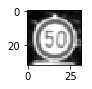

In [11]:
### First we convert to Grayscale which, according to Sermante and LeCun, actually improves the performance.

import math


def grayscale(img):    
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)    

X_train = np.array([grayscale(img) for img in X_train])
X_validation = np.array([grayscale(img) for img in X_validation])
X_test = np.array([grayscale(img) for img in X_test])

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()
plt.figure(figsize=(1,1))
plt.imshow(image, cmap='gray')
print(y_train[index])
#print(X_train[index])




2


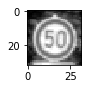

In [12]:
### We then perform histogram equalization, which improves the contrast in the images:
X_train = np.array([cv2.equalizeHist(img) for img in X_train])
X_validation = np.array([cv2.equalizeHist(img) for img in X_validation])
X_test = np.array([cv2.equalizeHist(img) for img in X_test])

X_train = np.array([np.reshape(img,(32,32,1)) for img in X_train])
X_validation = np.array([np.reshape(img,(32,32,1)) for img in X_validation])
X_test = np.array([np.reshape(img,(32,32,1)) for img in X_test])

image = X_train[index].squeeze()
plt.figure(figsize=(1,1))
plt.imshow(image, cmap='gray')
print(y_train[index])
#print(X_train[index])

2


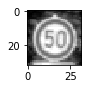

In [13]:
### Finally we normalize our data, image by image.
X_train = np.array([(img / 255.).astype(np.float32) for img in X_train])
X_validation = np.array([(img / 255.).astype(np.float32) for img in X_validation])
X_test = np.array([(img / 255.).astype(np.float32) for img in X_test])

image = X_train[index].squeeze()
plt.figure(figsize=(1,1))
plt.imshow(image, cmap='gray')
print(y_train[index])
#print(X_train[index])

### Model Architecture

In [14]:
# We pick the number of Epochs and the Batch size. We have a small batch size because we will apply data augmentation
# at the batch level, and thus we are using BATCH_SIZE times 6 data points.

import tensorflow as tf

EPOCHS = 15
BATCH_SIZE = 64
MIN_ACC = 0.0


In [15]:
# The architecture of our network resembles that of the Sermanet paper. The main idea
# is that the output of each convolution is later fed to a single fully connected layer
# with the idea that the outputs of different convolutions capture different features

# We are also using selu(x) as activation. This function induces self normalizing to the network.

from tensorflow.contrib.layers import flatten

keep_prob_ = tf.placeholder(tf.float32, name = "keep_prob")
rate_ = tf.placeholder(tf.float32, name = "rate")
layers = {}

def selu(x):
    alpha = 1.67
    scale = 1.05
    return scale*tf.where(x>=0, x, alpha*tf.nn.elu(x))

def LeNet(x):    
    
    mu = 0
    sigma = 0.1
    
    # Layer 1 Convolution
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 16), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(16))
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1 = selu(conv1)    
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    pool1 = tf.nn.dropout(conv1,keep_prob_*.95)

    # Layer 2 Convolution
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 32), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(32))
    conv2 = tf.nn.conv2d(pool1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b    
    conv2 = selu(conv2)
    pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    pool2 = tf.nn.dropout(pool2,keep_prob_*.9)
    
    # Layer 3 Convolution
    conv3_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 32, 32), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(32))
    conv3 = tf.nn.conv2d(pool2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b    
    conv3 = selu(conv3)
    pool3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    pool3 = tf.nn.dropout(pool3,keep_prob_*.85)              
    
    # Repool layers 1 and 2
    
    pool1 = tf.nn.max_pool(pool1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    pool2 = tf.nn.max_pool(pool2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')      
    
    # Flatten    
    fc0   = tf.concat(1,[flatten(pool3), flatten(pool2), flatten(pool1)])
   
    fc1_W = tf.Variable(tf.truncated_normal(shape=(4800, 512), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(512))
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b
    fc1 = selu(fc1)
    fc1 = tf.nn.dropout(fc1,keep_prob_*0.70)

    # Layer 4 Fully Connected
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(512, 256), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(256))
    fc2 = tf.matmul(fc1, fc2_W) + fc2_b
    fc2 = selu(fc2)
    fc2 = tf.nn.dropout(fc2,keep_prob_)

    # Layer 5 Fully Connected.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(256, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    global layers
    
    layers = {
        "input": x,
        "conv1": conv1,
        "pool1": pool1,
        "conv2": conv2,
        "pool2": pool2,
        "conv3": conv3,
        "pool3": pool3,
        "fc0": fc0,
        "fc1": fc1,
        "fc2": fc2,        
        "logits": logits
    }
    
    
    return logits

In [16]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

In [17]:
### It will be useful to define this function for evaluating our NN later on

from sklearn.metrics import precision_recall_fscore_support as score
import pandas
def get_precision_recall(y_data, y_predicted):
    precision, recall, fscore, support = score(y_data, y_predicted)
    pr = pandas.DataFrame({
        "name": signnames,
        "precision": precision,
        "recall": recall,        
    })
    print(pr)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [18]:
### Train your model here.


logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate_)
training_operation = optimizer.minimize(loss_operation)

In [19]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob_: 1.0, rate_:0.001})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [20]:

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            batch_x, batch_y = build_augmented_dataset(batch_x, batch_y)
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob_: 0.8, rate_:0.0003})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        training_accuracy = evaluate(X_train, y_train)
        
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Train Accuracy = {:.3f}".format(training_accuracy))
        
        if validation_accuracy > MIN_ACC:
            saver.save(sess, './lenet')
            print("Model saved")
            MIN_ACC = validation_accuracy
        print()     
    


Training...

EPOCH 1 ...
Validation Accuracy = 0.603
Train Accuracy = 0.628
Model saved

EPOCH 2 ...
Validation Accuracy = 0.814
Train Accuracy = 0.856
Model saved

EPOCH 3 ...
Validation Accuracy = 0.862
Train Accuracy = 0.919
Model saved

EPOCH 4 ...
Validation Accuracy = 0.905
Train Accuracy = 0.945
Model saved

EPOCH 5 ...
Validation Accuracy = 0.921
Train Accuracy = 0.963
Model saved

EPOCH 6 ...
Validation Accuracy = 0.940
Train Accuracy = 0.974
Model saved

EPOCH 7 ...
Validation Accuracy = 0.953
Train Accuracy = 0.981
Model saved

EPOCH 8 ...
Validation Accuracy = 0.951
Train Accuracy = 0.984

EPOCH 9 ...
Validation Accuracy = 0.951
Train Accuracy = 0.989

EPOCH 10 ...
Validation Accuracy = 0.953
Train Accuracy = 0.990
Model saved

EPOCH 11 ...
Validation Accuracy = 0.969
Train Accuracy = 0.992
Model saved

EPOCH 12 ...
Validation Accuracy = 0.966
Train Accuracy = 0.995

EPOCH 13 ...
Validation Accuracy = 0.968
Train Accuracy = 0.996

EPOCH 14 ...
Validation Accuracy = 0.968
Tr

In [21]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            batch_x, batch_y = build_augmented_dataset(batch_x, batch_y)
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob_: 0.7, rate_:0.0002})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        training_accuracy = evaluate(X_train, y_train)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Train Accuracy = {:.3f}".format(training_accuracy))
        
        if validation_accuracy > MIN_ACC:
            saver.save(sess, './lenet')
            print("Model saved")
            MIN_ACC = validation_accuracy
        print()         


Training...

EPOCH 1 ...
Validation Accuracy = 0.965
Train Accuracy = 0.992

EPOCH 2 ...
Validation Accuracy = 0.965
Train Accuracy = 0.991

EPOCH 3 ...
Validation Accuracy = 0.965
Train Accuracy = 0.993

EPOCH 4 ...
Validation Accuracy = 0.968
Train Accuracy = 0.994

EPOCH 5 ...
Validation Accuracy = 0.965
Train Accuracy = 0.992

EPOCH 6 ...
Validation Accuracy = 0.969
Train Accuracy = 0.995

EPOCH 7 ...
Validation Accuracy = 0.967
Train Accuracy = 0.996

EPOCH 8 ...
Validation Accuracy = 0.974
Train Accuracy = 0.996
Model saved

EPOCH 9 ...
Validation Accuracy = 0.971
Train Accuracy = 0.997

EPOCH 10 ...
Validation Accuracy = 0.974
Train Accuracy = 0.997

EPOCH 11 ...
Validation Accuracy = 0.973
Train Accuracy = 0.997

EPOCH 12 ...
Validation Accuracy = 0.975
Train Accuracy = 0.998
Model saved

EPOCH 13 ...
Validation Accuracy = 0.974
Train Accuracy = 0.998

EPOCH 14 ...
Validation Accuracy = 0.971
Train Accuracy = 0.998

EPOCH 15 ...
Validation Accuracy = 0.974
Train Accuracy = 0.99

In [22]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            batch_x, batch_y = build_augmented_dataset(batch_x, batch_y)
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob_: 0.6, rate_:0.0001})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        training_accuracy = evaluate(X_train, y_train)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Train Accuracy = {:.3f}".format(training_accuracy))
        
        if validation_accuracy > MIN_ACC:
            saver.save(sess, './lenet')
            print("Model saved")
            MIN_ACC = validation_accuracy
        print()   

Training...

EPOCH 1 ...
Validation Accuracy = 0.971
Train Accuracy = 0.997

EPOCH 2 ...
Validation Accuracy = 0.975
Train Accuracy = 0.998

EPOCH 3 ...
Validation Accuracy = 0.974
Train Accuracy = 0.997

EPOCH 4 ...
Validation Accuracy = 0.973
Train Accuracy = 0.997

EPOCH 5 ...
Validation Accuracy = 0.974
Train Accuracy = 0.997

EPOCH 6 ...
Validation Accuracy = 0.972
Train Accuracy = 0.998

EPOCH 7 ...
Validation Accuracy = 0.975
Train Accuracy = 0.998

EPOCH 8 ...
Validation Accuracy = 0.973
Train Accuracy = 0.998

EPOCH 9 ...
Validation Accuracy = 0.976
Train Accuracy = 0.997
Model saved

EPOCH 10 ...
Validation Accuracy = 0.975
Train Accuracy = 0.997

EPOCH 11 ...
Validation Accuracy = 0.977
Train Accuracy = 0.998
Model saved

EPOCH 12 ...
Validation Accuracy = 0.977
Train Accuracy = 0.998

EPOCH 13 ...
Validation Accuracy = 0.973
Train Accuracy = 0.998

EPOCH 14 ...
Validation Accuracy = 0.973
Train Accuracy = 0.998

EPOCH 15 ...
Validation Accuracy = 0.974
Train Accuracy = 0.99

In [23]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            batch_x, batch_y = build_augmented_dataset(batch_x, batch_y)
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob_: 0.5, rate_:0.0001})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        training_accuracy = evaluate(X_train, y_train)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Train Accuracy = {:.3f}".format(training_accuracy))
        
        if validation_accuracy > MIN_ACC:
            saver.save(sess, './lenet')
            print("Model saved")
            MIN_ACC = validation_accuracy
        print()    

Training...

EPOCH 1 ...
Validation Accuracy = 0.972
Train Accuracy = 0.997

EPOCH 2 ...
Validation Accuracy = 0.973
Train Accuracy = 0.997

EPOCH 3 ...
Validation Accuracy = 0.974
Train Accuracy = 0.996

EPOCH 4 ...
Validation Accuracy = 0.972
Train Accuracy = 0.996

EPOCH 5 ...
Validation Accuracy = 0.970
Train Accuracy = 0.996

EPOCH 6 ...
Validation Accuracy = 0.974
Train Accuracy = 0.996

EPOCH 7 ...
Validation Accuracy = 0.974
Train Accuracy = 0.996

EPOCH 8 ...
Validation Accuracy = 0.972
Train Accuracy = 0.997

EPOCH 9 ...
Validation Accuracy = 0.971
Train Accuracy = 0.997

EPOCH 10 ...
Validation Accuracy = 0.972
Train Accuracy = 0.996

EPOCH 11 ...
Validation Accuracy = 0.973
Train Accuracy = 0.997

EPOCH 12 ...
Validation Accuracy = 0.974
Train Accuracy = 0.997

EPOCH 13 ...
Validation Accuracy = 0.973
Train Accuracy = 0.996

EPOCH 14 ...
Validation Accuracy = 0.976
Train Accuracy = 0.997

EPOCH 15 ...
Validation Accuracy = 0.973
Train Accuracy = 0.997



In [24]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    validation_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(validation_accuracy))
    print(" ")
    data_logits = sess.run(logits, feed_dict={x: X_test, keep_prob_: 1.0})
    y_predicted = np.array([ l.argmax() for l in data_logits])    
    get_precision_recall(y_test, y_predicted)

Test Accuracy = 0.958
 
                                                 name  precision    recall
0                                Speed limit (20km/h)   0.979592  0.800000
1                                Speed limit (30km/h)   0.950135  0.979167
2                                Speed limit (50km/h)   0.967575  0.994667
3                                Speed limit (60km/h)   0.979499  0.955556
4                                Speed limit (70km/h)   0.969651  0.968182
5                                Speed limit (80km/h)   0.935535  0.944444
6                         End of speed limit (80km/h)   1.000000  0.766667
7                               Speed limit (100km/h)   0.959732  0.953333
8                               Speed limit (120km/h)   0.952174  0.973333
9                                          No passing   0.956175  1.000000
10       No passing for vehicles over 3.5 metric tons   0.990909  0.990909
11              Right-of-way at the next intersection   0.921801  0.926190
1

---

## Step 3: Test a Model on New Images

We downloaded 10 more German traffic signs images from the web. The idea is to use them to further test our classifier. In order to make them usable, we sometimes cropped the images to get a similar result to the one we have in our dataset.
Below are the images we will use, resized to 32 by 32 bits, just like the ones we have been working on.

### Load and Output the Images

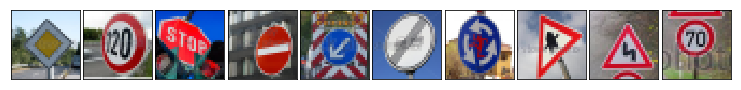

In [25]:
### Loading and plotting the new images

imgs = []

for i in range(10):
    filename = "examples/newImage{}.jpg".format(i)
    img = cv2.imread(filename)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(img, (32,32), interpolation=cv2.INTER_AREA)
    imgs.append(resized)

X_challenge = np.stack(imgs)

fig = plt.figure(figsize = (10, 1))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)

for i in range(len(X_challenge)):
    axis = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
    axis.imshow(X_challenge[i])
plt.show()

### Predict the Sign Type for Each Image

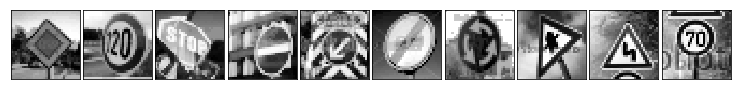

In [34]:
### We begin by preprocessing the new images just like we did for the original data set

X_challenge = np.array([grayscale(img) for img in imgs])
X_challenge = np.array([cv2.equalizeHist(img) for img in X_challenge])
X_challenge = np.array([np.reshape(img,(32,32,1)) for img in X_challenge])
X_challenge = np.array([(img / 255.).astype(np.float32) for img in X_challenge])

fig = plt.figure(figsize = (10, 1))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)

for i in range(len(X_challenge)):
    axis = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])    
    axis.imshow(np.reshape(X_challenge[i],(32,32)), cmap='gray')
plt.show()


In [44]:
# We now run our classifier

with tf.Session() as sess:
    # Restore session    
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    print("Session restored.")
    data_logits = sess.run(logits, feed_dict={x: X_challenge, keep_prob_: 1.0})
    y_predicted = np.array([ l.argmax() for l in data_logits])
    print(y_predicted)
    print(signnames[y_predicted])

Session restored.
[12  5 14 36  4 41 40 33 21  3]
['Priority road' 'Speed limit (80km/h)' 'Stop' 'Go straight or right'
 'Speed limit (70km/h)' 'End of no passing' 'Roundabout mandatory'
 'Turn right ahead' 'Double curve' 'Speed limit (60km/h)']


### Analyze Performance

In [50]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

y_challenge = np.array([12, 8, 14, 17, 39, 41, 40, 11, 21, 4])

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    print("Session restored.")
    data_logits = sess.run(logits, feed_dict={x: X_challenge, keep_prob_: 1.0})
    y_predicted = np.array([ l.argmax() for l in data_logits])
    print(y_predicted)
    print(y_challenge)
    acc = 0.0
    for i in range(len (y_challenge)):
        if y_challenge[i] == y_predicted[i]:
            acc = acc + 1
    acc = acc/len(y_predicted)
    print("Accuracy:", acc)

Session restored.
[12  5 14 36  4 41 40 35 21  3]
[12  8 14 17 39 41 40 11 21  4]
Accuracy: 0.5


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 


In [49]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    print("")
    logit_values = sess.run(logits, feed_dict={x: X_challenge, y: y_challenge, keep_prob_: 1.0})
    top_args = np.argsort(logit_values, axis=1)[:,::-1][:,:5]
    top_args_logits = np.sort(logit_values, axis=1)[:,::-1][:,:5]
    top_args_logits = np.around(top_args_logits, decimals=3)
    top_args_probs = [softmax(v) for v in top_args_logits]
    print(top_args)    
    print(top_args_probs)
    


[[12 40  9 32  7]
 [ 5  8  1  0  3]
 [25 30  5  3 19]
 [36 17  9 38 14]
 [ 4 14 25 39  1]
 [41 32 42  6 36]
 [40 12  7  2  1]
 [25 33 18 35 39]
 [21 11 31 24 25]
 [ 3  8  5  2  1]]
[array([  1.00000000e+00,   1.27285893e-09,   1.11545850e-09,
         8.37164116e-10,   6.57878918e-10], dtype=float32), array([ 0.58105475,  0.32370898,  0.0422179 ,  0.02746315,  0.02555529], dtype=float32), array([ 0.34287637,  0.224611  ,  0.16099447,  0.14321829,  0.12829985], dtype=float32), array([  9.10125256e-01,   8.93519521e-02,   2.29599784e-04,
         1.55296759e-04,   1.38011615e-04], dtype=float32), array([ 0.33110064,  0.25174642,  0.18335465,  0.16807702,  0.06572125], dtype=float32), array([  6.26261234e-01,   3.11926931e-01,   4.02362607e-02,
         2.15584561e-02,   1.71418578e-05], dtype=float32), array([ 0.63763225,  0.3436974 ,  0.00822158,  0.00819695,  0.00225187], dtype=float32), array([ 0.58893174,  0.13419716,  0.12829216,  0.09734974,  0.05122922], dtype=float32), array([  

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 In this section we are just using the function provided to us to visualize the feature maps of our network. In this way, we can get some insight into what each layer of our classifier is focusing on, which allows us to get a better understanding of our model, and hopefully some clues about what makes it work and how can it be improved.


In [47]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, string_name, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input, keep_prob_:1.0})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
        plt.savefig("examples/features_{}.png".format(str(featuremap) + string_name))
        

Session restored.


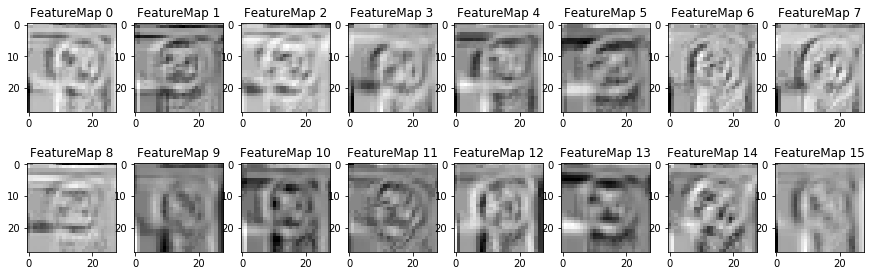

In [51]:
index = random.randint(0, n_train-1) # upper bound is inclusive here
image_in = np.array([X_train[index]])

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    print("Session restored.")
    outputFeatureMap(image_in, layers["conv1"], "conv1")
    #outputFeatureMap(image_in, layers["conv2"], "conv2")
    #outputFeatureMap(image_in, layers["conv3"], "conv3")